In [1]:
import mido # easy to use python MIDI library
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import random
import pandas as pd
import random
import math

from mido import MidiFile, MidiTrack, Message

import pickle

from sklearn import model_selection

In [2]:
def track_to_data(track):
    l = []
    for msg in track:
        if msg.type == 'note_on':
            note = msg.note
            velocity = msg.velocity
            time = msg.time
            l.append([note, velocity, time])
    return(l)

In [20]:
def midi_to_data(midi, track_name = 'right', return_track = False):
    a = 0
    for track in mid_file.tracks:
        if track.name == f'Piano {track_name}' or track.name == f'Piaro {track_name}' or track.name == track_name.capitalize():
            my_track = track
            a = 1
    if a == 0:
        if len(mid_file.tracks) == 1:
            my_track = mid_file.tracks[0]
        else:
            print(f'Piano {track} not found')
            print(mid_file.tracks)
            return []
    my_track, data = transform_track(my_track)
    
    if return_track:
        return data, my_track 
        
    return data

In [21]:
def data_to_track(data):
    track = MidiTrack()
    for values in data:
        note = values[0]
        velocity = values[1]
        time = values[2]
        track.append(Message('note_on', channel=0, note=note, velocity=velocity, time=time))
    return(track)
    

In [22]:
def transform_track(track):
    data_1 = []
    time = 0
    for msg_id in range(len(track)):
        msg = track[msg_id]
        time += msg.time
        if msg.type == 'note_on':
            if msg.velocity > 0:
                msg_note = msg.note
                dur = 0
                for i in range(msg_id+1, len(track)):
                    dur += track[i].time
                    if track[i].type == 'note_on':
                        if track[i].velocity == 0 and track[i].note == msg_note:
                            break
                l = [msg.note, msg.velocity, dur, time]
                data_1.append(l)
    
    track_new = MidiTrack()
    time_init = 0
    
    data_2 = []
    for l in data_1:
        note = l[0]
        velocity = l[1]
        time = l[3] - time_init
        time_init = l[3]
        l = [note, velocity, l[2], time, l[3], l[3] + l[2]]
        data_2.append(l)

        track_new.append(Message('note_on', channel=0, note=note, velocity=velocity, time=time))
    
    return track_new, data_2

In [23]:
def save_track(tracks, path):
    mid = MidiFile()
    for track in tracks:
        mid.tracks.append(track)
    mid.save(path)

# Iverse Transform

In [24]:
def concatenate_and_filter(sequences_param, seq_length, stick = False):
    
    sequences = sequences_param.copy()
    
    data_sequence = []
    
    t = 0
    t_last = 0
    
    num_seq = 0
    
    for seq in sequences:
        
        t = num_seq * seq_length
        
        for l in seq:
            
            t += l[3]
            
            if l != [-1, -1, -1, -1] and l != [-2, -2, -2, -2] and l != [-3, -3, -3, -3]:
                
                if stick == True and len(data_sequence) > 0 and l[:2] == data_sequence[-1][:2]:
                    data_sequence[-1][2] += l[2]
                    
                else:
                
                    '''
                    print('-----------------------------')
                    print(t)
                    print(t_last)
                    print(l)
                    '''

                    l[3] = t - t_last
                    t_last = t

                    #print(l)

                    data_sequence.append(l)
                
        num_seq += 1
    
    return data_sequence

In [25]:
def concatenate_and_filter_2(sequences_param, seq_length, stick = False, cut_dur=False ):
    
    sequences = sequences_param.copy()
    
    data_sequence = []
    
    t = 0
    t_last_start = 0
    t_end = []
    
    num_seq = 0
    
    for seq in sequences:
        
        t = num_seq * seq_length
        
        for l in seq:
            
            t += l[3]
            
            
            if cut_dur and t + l[2] > (num_seq+1) * seq_length:
                        l[2] = (num_seq+1) * seq_length - t
                    
                    
            if l != [-1, -1, -1, -1] and l != [-2, -2, -2, -2] and l != [-3, -3, -3, -3]:
                
                if stick == True:
                    
                    sticked = False
                    
                    for i in range(len(data_sequence)):
                        if t == t_end[i] and l[:2] == data_sequence[i][:2]:
                            data_sequence[i][2] += l[2]
                            t_end[i] = t + l[2]
                            sticked = True
                            break
                            
                    
                if (stick == True and sticked == False) or stick == False:
                
                    l[3] = t - t_last_start
                    t_last_start = t
                    
                    t_end.append(t_last_start + l[2])

                    data_sequence.append(l)
                
        num_seq += 1
    
    return data_sequence

In [26]:
def generate_inverse_midi(data_sequence):
    track_new = MidiTrack()
    
    abs_time = 0
    messages = []
    
    for note_vect in data_sequence:
        abs_time += note_vect[3]
        messages.append([abs_time, note_vect[1], note_vect[0]])
        messages.append([abs_time + note_vect[2], 0, note_vect[0]])
    
    messages.sort()
    
    #print(messages)
    
    time_init = 0
    
    messages_2 = []
    for l in messages:
        note = l[2]
        velocity = l[1]
        time = l[0] - time_init
        time_init = l[0]
        track_new.append(Message('note_on', channel=0, note=note, velocity=velocity, time=time))
    
    return track_new

# Plot function

In [29]:
def plot_data(data, length = -1):
    t = 0
    
    plt.figure(figsize = (30, 5))
    
    for i, vec in enumerate(data):
        
        notes = []
        time = []
        
        t += vec[3]
        time.append(t)
        notes.append(vec[0])
        notes.append(vec[0])
        t += vec[2]
        time.append(t)
        
        plt.plot(time, notes, 'b')
        
        if length > 0 and i == length:
            break
    

# Plot tracks

In [47]:
save_folder_path = 'C:/Users/maxim/Desktop/generated_musics_plots'

## Mendelssohn

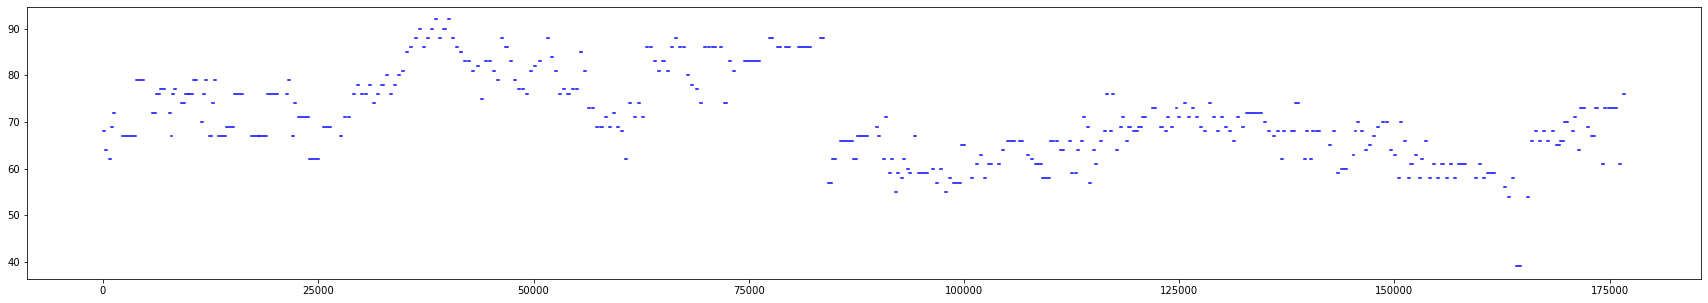

In [48]:
path_midi = 'C:/Users/maxim/Desktop/RNN_cond_all_128x3_512_mendel_1.5_1.5_1.5_.mid'
mid_file = MidiFile(path_midi, clip=True)
data_r = midi_to_data(mid_file, 'right')
plot_data(data_r, length = 300)
plt.savefig(os.path.join(save_folder_path,'mendelssohn_generated.png'))

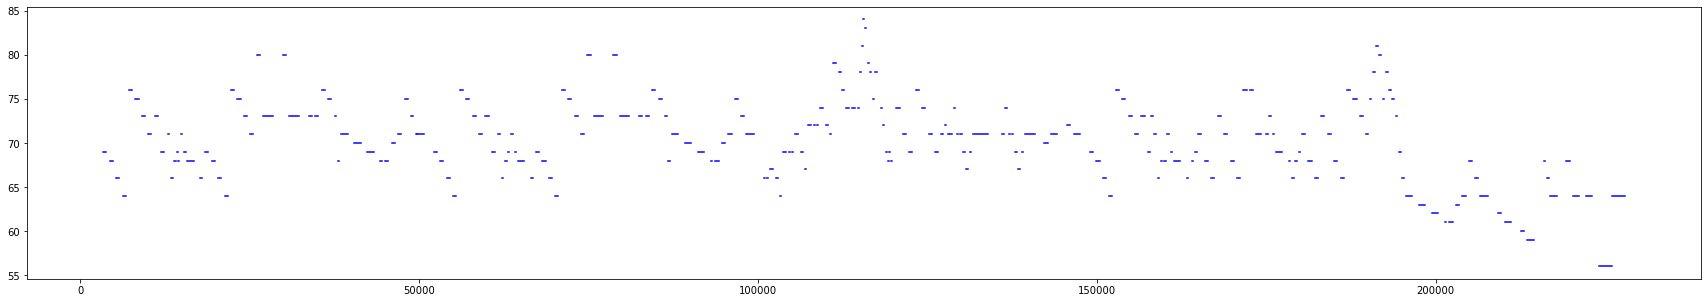

In [49]:
path_midi = 'C:/Users/maxim/Desktop/DL_project/piano_dataset/mendelssohn/mendel_op19_1.mid'
mid_file = MidiFile(path_midi, clip=True)
data_r = midi_to_data(mid_file, 'right')
plot_data(data_r, length = 300)
plt.savefig(os.path.join(save_folder_path,'mendelssohn_1.png'))

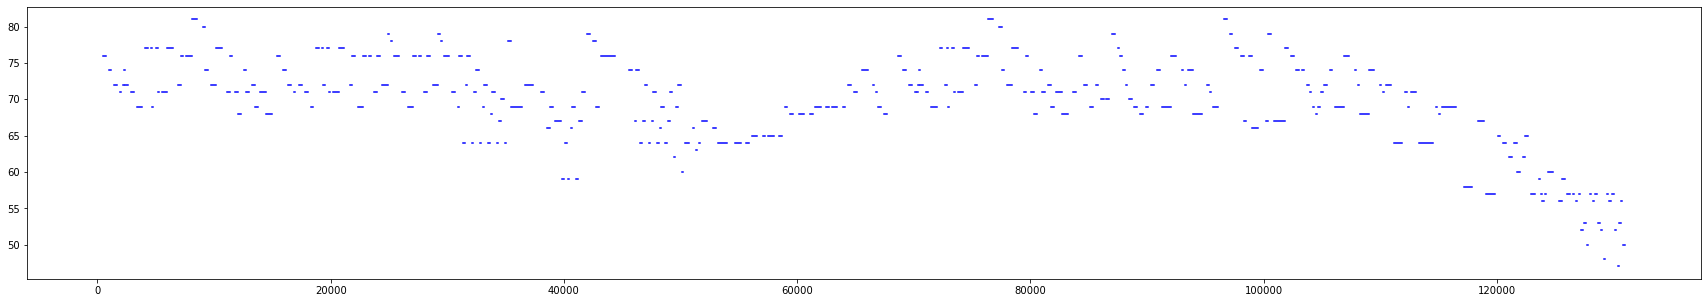

In [50]:
path_midi = 'C:/Users/maxim/Desktop/DL_project/piano_dataset/mendelssohn/mendel_op19_2.mid'
mid_file = MidiFile(path_midi, clip=True)
data_r = midi_to_data(mid_file, 'right')
plot_data(data_r, length = 300)
plt.savefig(os.path.join(save_folder_path,'mendelssohn_2.png'))

## Mozart

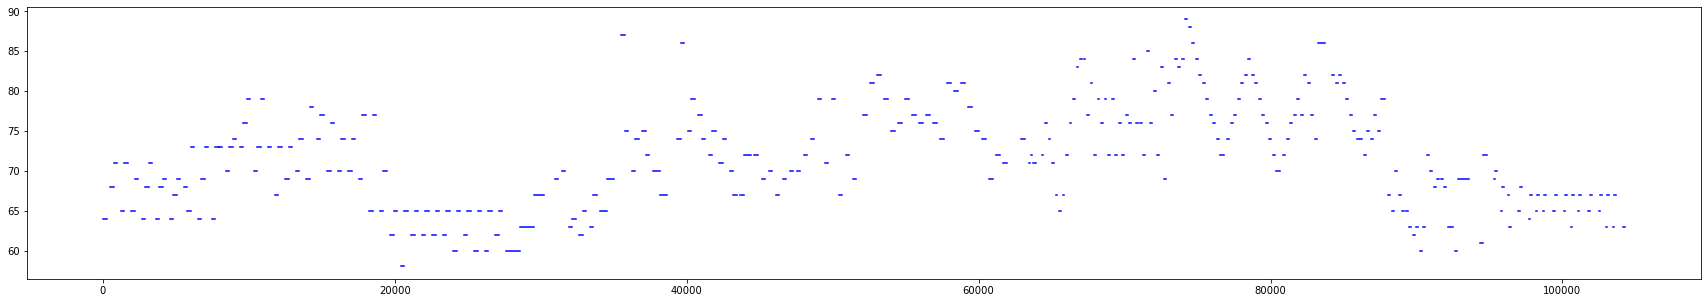

In [51]:
path_midi = 'C:/Users/maxim/Desktop/RNN_cond_all_128x3_512_mozart_1.5_1.5_1.5_.mid'
mid_file = MidiFile(path_midi, clip=True)
data_r = midi_to_data(mid_file, 'right')
plot_data(data_r, length = 300)
plt.savefig(os.path.join(save_folder_path,'mozart_generated.png'))

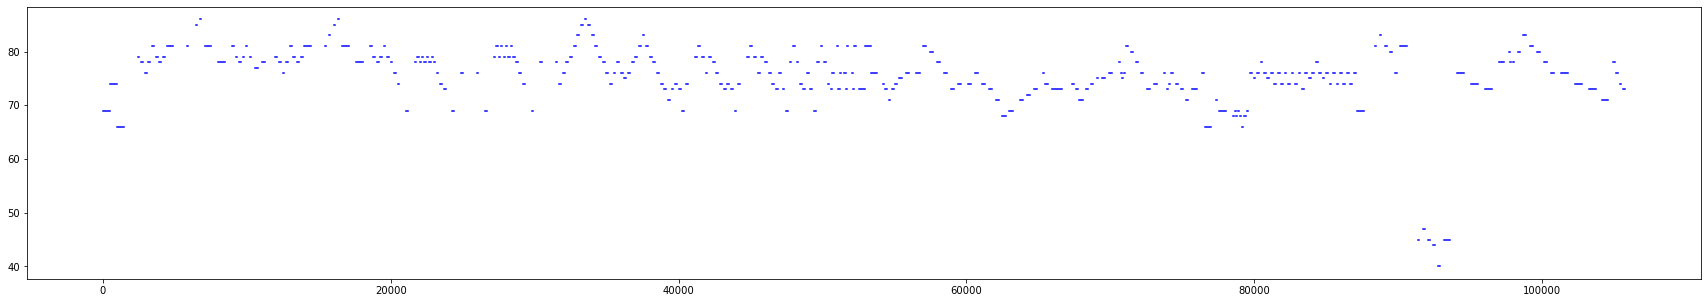

In [52]:
path_midi = 'C:/Users/maxim/Desktop/DL_project/piano_dataset/mozart/mz_311_1.mid'
mid_file = MidiFile(path_midi, clip=True)
data_r = midi_to_data(mid_file, 'right')
plot_data(data_r, length = 300)
plt.savefig(os.path.join(save_folder_path,'mozart_1.png'))

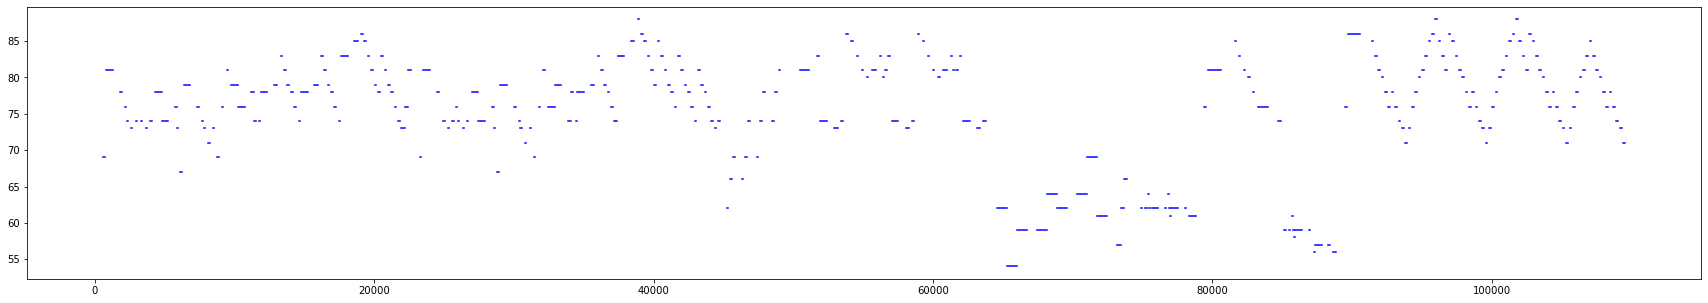

In [53]:
path_midi = 'C:/Users/maxim/Desktop/DL_project/piano_dataset/mozart/mz_311_3.mid'
mid_file = MidiFile(path_midi, clip=True)
data_r = midi_to_data(mid_file, 'right')
plot_data(data_r, length = 300)
plt.savefig(os.path.join(save_folder_path,'mozart_2.png'))

## Schubert

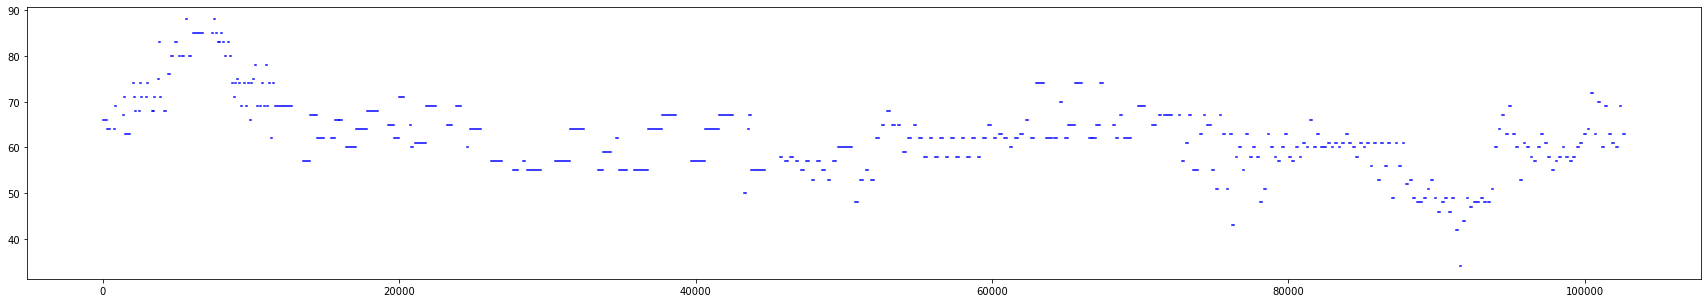

In [54]:
path_midi = 'C:/Users/maxim/Desktop/RNN_cond_all_128x3_512_schubert_1.5_1.5_1.5_.mid'
mid_file = MidiFile(path_midi, clip=True)
data_r = midi_to_data(mid_file, 'right')
plot_data(data_r, length = 300)
plt.savefig(os.path.join(save_folder_path,'schubert_generated.png'))

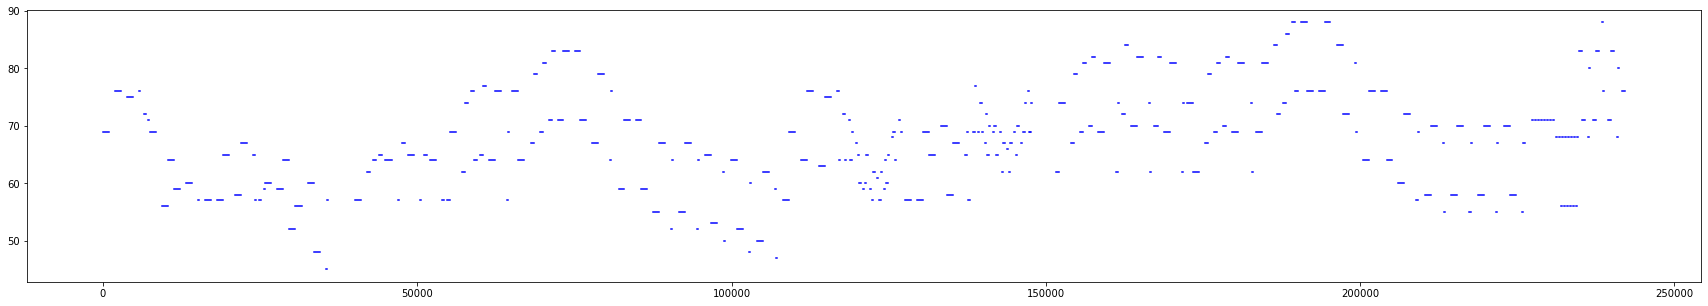

In [55]:
path_midi = 'C:/Users/maxim/Desktop/DL_project/piano_dataset/schubert/schu_143_1.mid'
mid_file = MidiFile(path_midi, clip=True)
data_r = midi_to_data(mid_file, 'right')
plot_data(data_r, length = 300)
plt.savefig(os.path.join(save_folder_path,'schubert_1.png'))

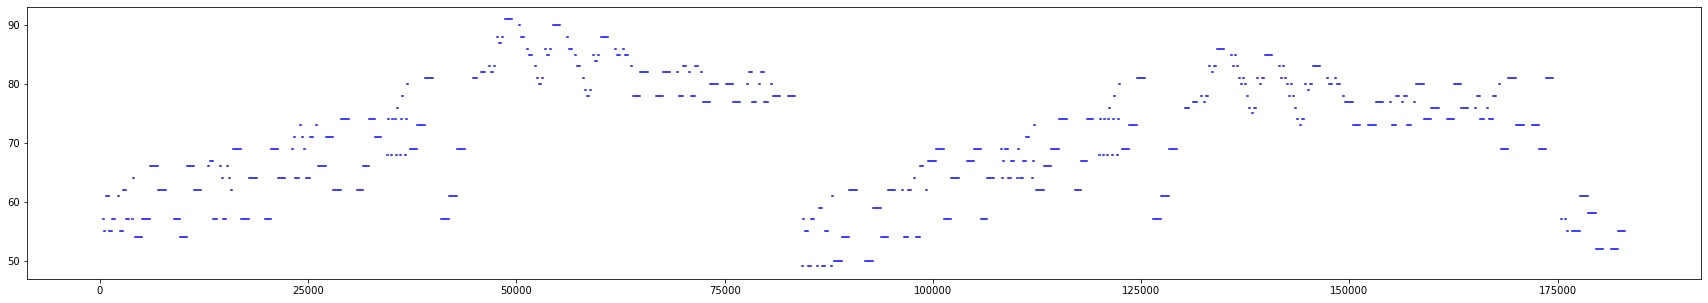

In [56]:
path_midi = 'C:/Users/maxim/Desktop/DL_project/piano_dataset/schubert/schubert_D850_3.mid'
mid_file = MidiFile(path_midi, clip=True)
data_r = midi_to_data(mid_file, 'right')
plot_data(data_r, length = 300)
plt.savefig(os.path.join(save_folder_path,'schubert_2.png'))

## Basic model

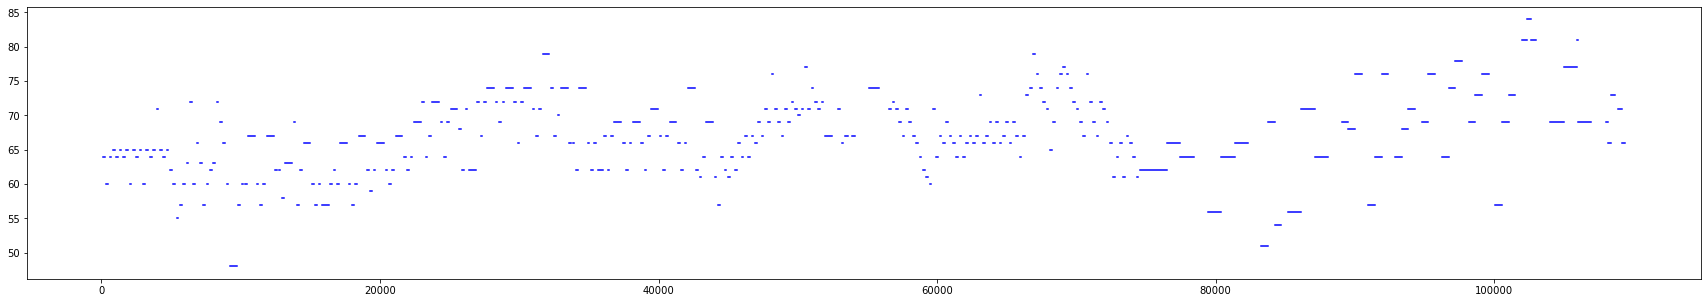

In [70]:
path_midi = 'C:/Users/maxim/Desktop/RNN_cond_all_128x3_512_cond_1.5_1.5_1.5_V4.mid'
mid_file = MidiFile(path_midi, clip=True)
data_r = midi_to_data(mid_file, 'right')
plot_data(data_r, length = 300)
plt.savefig(os.path.join(save_folder_path,'basic_1.png'))

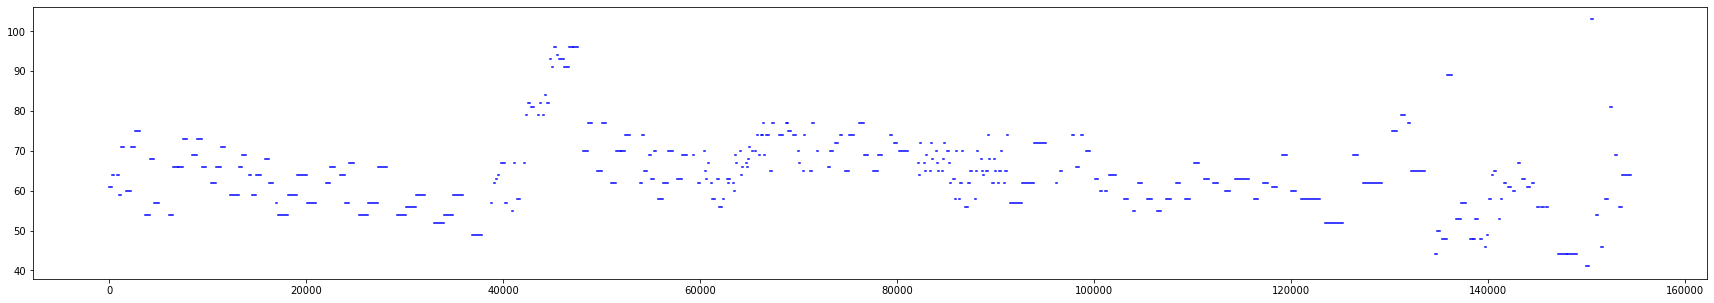

In [60]:
path_midi = 'C:/Users/maxim/Desktop/RNN_cond_all_128x3_512_ep100_1.5_1.5_1.5_V1.mid'
mid_file = MidiFile(path_midi, clip=True)
data_r = midi_to_data(mid_file, 'right')
plot_data(data_r, length = 300)
plt.savefig(os.path.join(save_folder_path,'basic_2.png'))

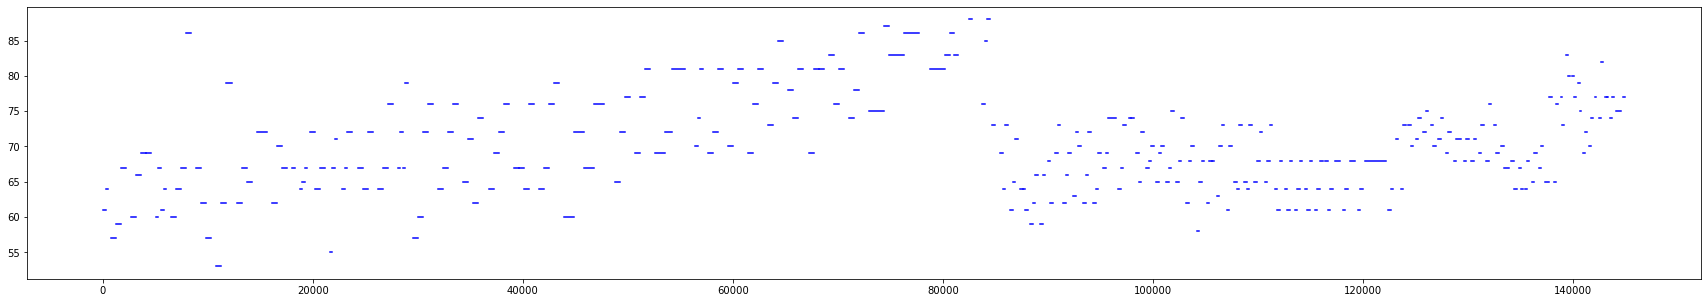

In [61]:
path_midi = 'C:/Users/maxim/Desktop/RNN_cond_all_128x3_512_ep100_1.5_1.5_1.5_V0.mid'
mid_file = MidiFile(path_midi, clip=True)
data_r = midi_to_data(mid_file, 'right')
plot_data(data_r, length = 300)
plt.savefig(os.path.join(save_folder_path,'basic_3.png'))

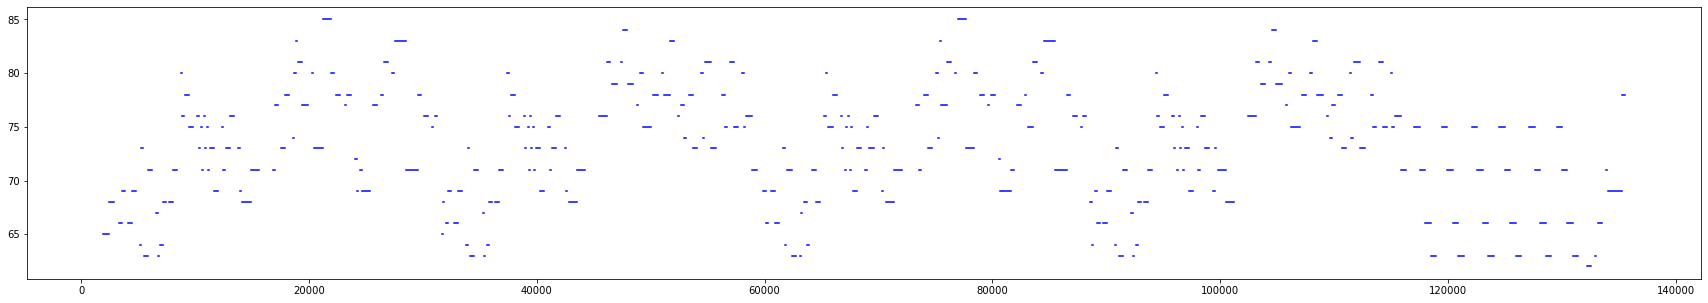

In [63]:
path_midi = 'C:/Users/maxim/Desktop/DL_project/piano_dataset/Albéniz/alb_esp6.mid'
mid_file = MidiFile(path_midi, clip=True)
data_r = midi_to_data(mid_file, 'right')
plot_data(data_r, length = 300)
plt.savefig(os.path.join(save_folder_path,'alb_1.png'))

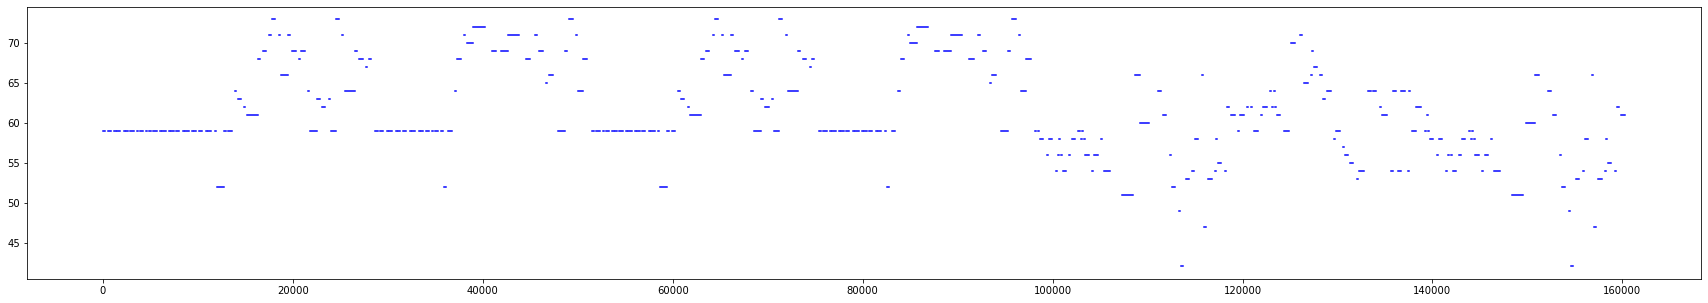

In [64]:
path_midi = 'C:/Users/maxim/Desktop/DL_project/piano_dataset/Albéniz/alb_esp6.mid'
mid_file = MidiFile(path_midi, clip=True)
data_r = midi_to_data(mid_file, 'left')
plot_data(data_r, length = 300)
plt.savefig(os.path.join(save_folder_path,'alb_2.png'))